# Intro a procesamiento de imágenes con python

Pillow: https://pillow.readthedocs.io/en/3.0.x/handbook/tutorial.html

OpenCV: https://docs.opencv.org/4.1.1/d6/d00/tutorial_py_root.html

In [3]:
# imports
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2

# mostrar imágenes y figuras inline
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = 12, 12

## Operaciones básicas

(640, 426, 3) uint8


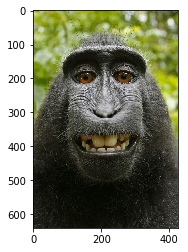

In [4]:
# con Pillow
img = Image.open("images/selfie.jpg")
img = np.array(img)
print(img.shape, img.dtype)
plt.imshow(img)

(640, 426, 3) uint8


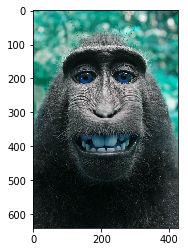

In [5]:
# con OpenCV
img = cv2.imread("images/selfie.jpg")
print(img.shape, img.dtype)
plt.imshow(img)

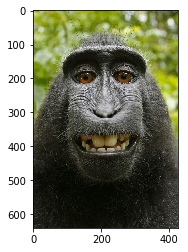

In [6]:
# ¿que pasó? OpenCV usa el formato BGR
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
# también se puede hacer img[..., ::-1]. ¿Cuál es la diferencia?
# img = img[..., ::-1]
plt.imshow(img)

In [7]:
# acceso a un pixel particular
px = img[100,100][:] 
print(px)

[163 177 116]


In [ ]:
# ojo con las referencias!
img[100,100] = [255,255,255]
print(px)

uint8


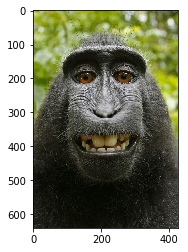

In [8]:
# Las imágenes también pueden estar representadas en punto flotante, pero cuidado con los rangos
print(img.dtype)
img_float = img.astype(np.float32)
plt.imshow(img_float/255.)

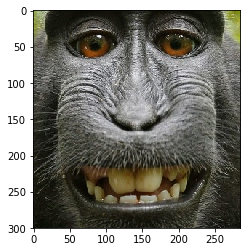

In [9]:
# ROI (Region of interest)
crop = img[150:450, 70:-70]
plt.imshow(crop)

In [10]:
# guardar imágenes en distintos formatos
crop = cv2.cvtColor(crop, cv2.COLOR_RGB2BGR)
cv2.imwrite("images/crop.jpg", crop)
cv2.imwrite("images/crop.png", crop)
cv2.imwrite("images/crop.tif", crop)
cv2.imwrite("images/crop.pnm", crop)

True

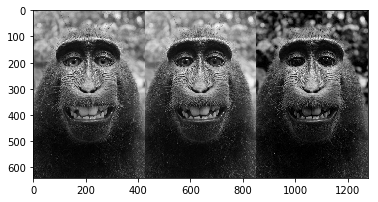

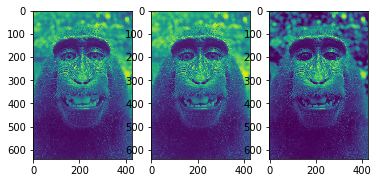

In [11]:
# también podemos trabajar con canales indviduales
img_r, img_g, img_b = img[..., 0], img[..., 1], img[..., 2]
tile = np.hstack([img_r, img_g, img_b])
plt.imshow(tile, cmap='gray')
#plt.imshow(tile)

plt.figure()
plt.subplot(1,3,1); plt.imshow(img_r)
plt.subplot(1,3,2); plt.imshow(img_g)
plt.subplot(1,3,3); plt.imshow(img_b)

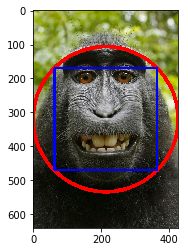

In [12]:
# y anotar las imágenes (el "print debug" en vision)
visu = img[..., ::-1].copy()  # crear una copia nueva
h, w, _ = img.shape
cv2.circle(visu, (w//2, h//2), w//2, (0,0,255), 10)
cv2.rectangle(visu, (w//2-150, h//2-150), (w//2+150, h//2+150), (255,0,0), 5)
plt.imshow(cv2.cvtColor(visu, cv2.COLOR_BGR2RGB))

## Filtros

In [ ]:
def correlation_filter(image, kernel):
    assert kernel.ndim == 2 
    kh, kw = kernel.shape
    assert kh % 2 == 1 and kw % 2 == 1
    
    assert image.ndim == 3 
    ih, iw, ic = image.shape
    
    output = np.zeros(image.shape)
    for i in range(kh//2, ih-kh//2):   
        for j in range(kw//2, iw-kw//2):
            for c in range(ic):
                output[i, j, c] = (kernel * image[i-kh//2:i+kh//2+1, j-kw//2:j+kw//2+1, c]).sum()
     
    return output.astype(image.dtype)

In [ ]:
# suavizado con un filtro box y función custom
kernel = np.ones((15, 15), np.float32)
kernel /= kernel.sum()

%timeit -r1 res = correlation_filter(img, kernel)

plt.subplot(1,2,1); plt.imshow(img)
plt.subplot(1,2,2); plt.imshow(res)

In [ ]:
# ... o usando OpenCV

res1 = cv2.filter2D(img, -1, kernel, cv2.BORDER_REPLICATE)
res2 = cv2.GaussianBlur(img, (0,0), 5, cv2.BORDER_REPLICATE)

plt.subplot(1,3,1); plt.imshow(img)
plt.subplot(1,3,2); plt.imshow(res1)
plt.subplot(1,3,3); plt.imshow(res2)

In [ ]:
# respuesta al impulso
delta = np.zeros((128, 128), dtype=np.float32)
delta[64, 64] = 1.
res = cv2.GaussianBlur(delta, (0,0), 25, cv2.BORDER_REPLICATE)
plt.imshow(res, cmap='gray')

## Gradientes

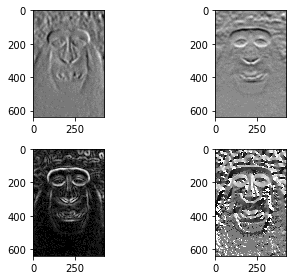

In [13]:
# gradiente a mano
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
kernel_x = np.array([[-1, 1]], dtype=np.float32)
kernel_y = np.array([[-1], [1]], dtype=np.float32)
#kernel_x = np.array([[-0.5, 0., 0.5]], dtype=np.float32)
#kernel_y = np.array([[-0.5], [0.], [0.5]], dtype=np.float32)

gray = np.float32(cv2.GaussianBlur(gray, (0, 0), 5))
gx = cv2.filter2D(gray, -1, kernel_x, cv2.BORDER_REPLICATE)
gy = cv2.filter2D(gray, -1, kernel_y, cv2.BORDER_REPLICATE)
gnorm = (gx**2 + gy**2) ** 0.5
garg = np.arctan2(gy, gx)

plt.figure()
plt.subplot(2,2,1); plt.imshow(gx, cmap='gray')
plt.subplot(2,2,2); plt.imshow(gy, cmap='gray')
plt.subplot(2,2,3); plt.imshow(gnorm, cmap='gray')
plt.subplot(2,2,4); plt.imshow(garg, cmap='gray')
plt.tight_layout()

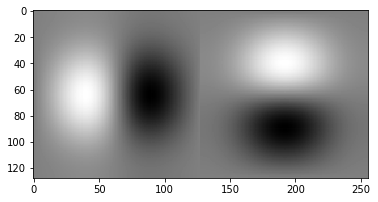

In [14]:
# respuesta al impulso
delta = np.zeros((128, 128), dtype=np.float32)
delta[64, 64] = 1
res = cv2.GaussianBlur(delta, (0,0), 25, cv2.BORDER_REPLICATE)
gx = cv2.filter2D(res, -1, kernel_x, cv2.BORDER_REPLICATE)
gy = cv2.filter2D(res, -1, kernel_y, cv2.BORDER_REPLICATE)
plt.imshow(np.hstack([gx, gy]), cmap='gray')

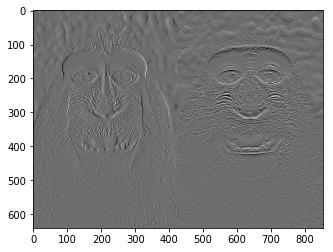

In [15]:
# derivadas con kernels de Sobel (derivada + suavizado)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gx = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=5)
gy = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=5)
plt.imshow(np.hstack([gx, gy]), cmap='gray')